In [1]:
%matplotlib inline
timeSz = 32
from MakeModels import *
encoder = makeEncoder(timeSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

nFeatures = autoencoder.layers[-2].output_shape[-1]+4

Using TensorFlow backend.


In [ ]:
decoder.summary()

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import sklearn.decomposition as decomposition
from IPython.core.debugger import Pdb

feats = np.load('/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy')

feats = feats[:,:-4]

def makeFeatureGood(feature):
    feature = np.expand_dims(feature,axis=0)
    feature = np.expand_dims(feature,axis=0)
    feature = np.expand_dims(feature,axis=0)
    return feature


pca = decomposition.PCA(n_components=5)
pca.fit(feats)
print pca.components_.shape

(5, 25)


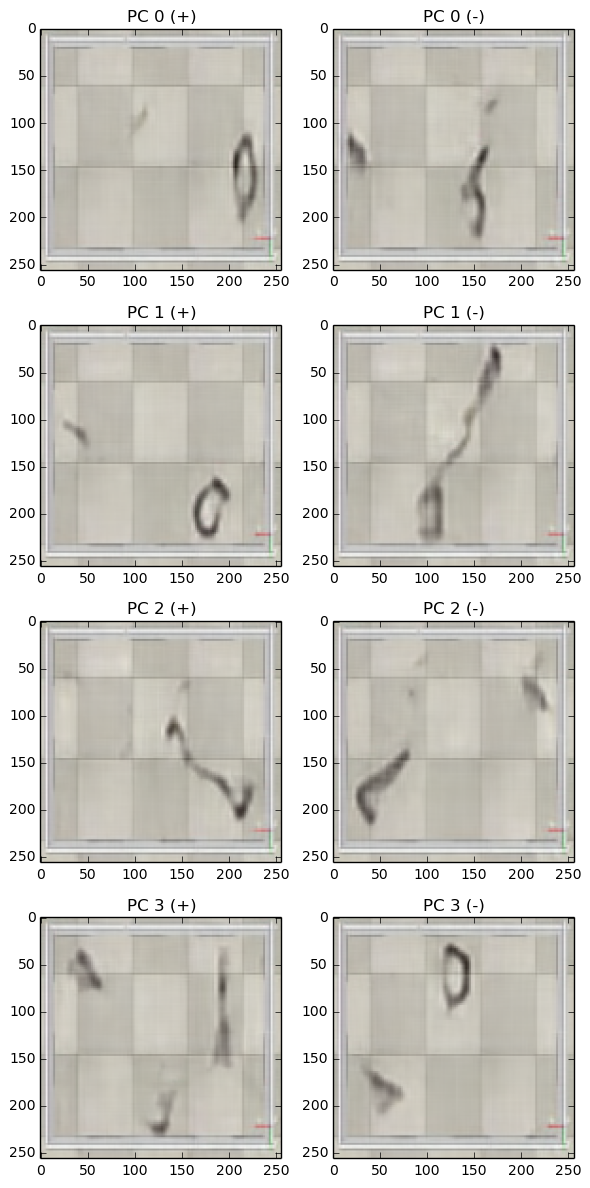

In [11]:
# mn = makeFeatureGood(np.mean(feats))
mn = np.mean(feats)

# im_out = decoder.predict(makeFeatureGood(mn))
# plt.figure()
# plt.imshow(im_out[0,:])

ncomponents = 4
fig,axes = plt.subplots(nrows=ncomponents,ncols=2,figsize=(6,12))
for i in range(ncomponents):
    im_out = decoder.predict(makeFeatureGood(mn+pca.components_[i,:]*5e3))
    plt.subplot(ncomponents,2,2*i+1)
    plt.imshow(im_out[0,:])
    plt.title('PC %d (+)' % i)
    im_out = decoder.predict(makeFeatureGood(mn-pca.components_[i,:]*5e3))
    plt.subplot(ncomponents,2,2*i+2)
    plt.imshow(im_out[0,:])
    plt.title('PC %d (-)' % i)
    
fig.tight_layout()
fig.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/PCA.pdf',format='pdf')

In [13]:
from sklearn.neighbors import NearestNeighbors


randomFeatIdxs = np.random.randint(0,feats.shape[0],size=(2000,))
randomFeats = feats[randomFeatIdxs,:]
print randomFeats.shape 
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(randomFeats)

(2000, 25)


In [14]:
distances, indices = nbrs.kneighbors(randomFeats)

print indices

[[   0 1280  436 1018 1065]
 [   1  914 1847 1252 1341]
 [   2 1897  341  615 1511]
 ..., 
 [1997 1396  480 1715   18]
 [1998 1100  625  540  221]
 [1999  523   25  923 1300]]


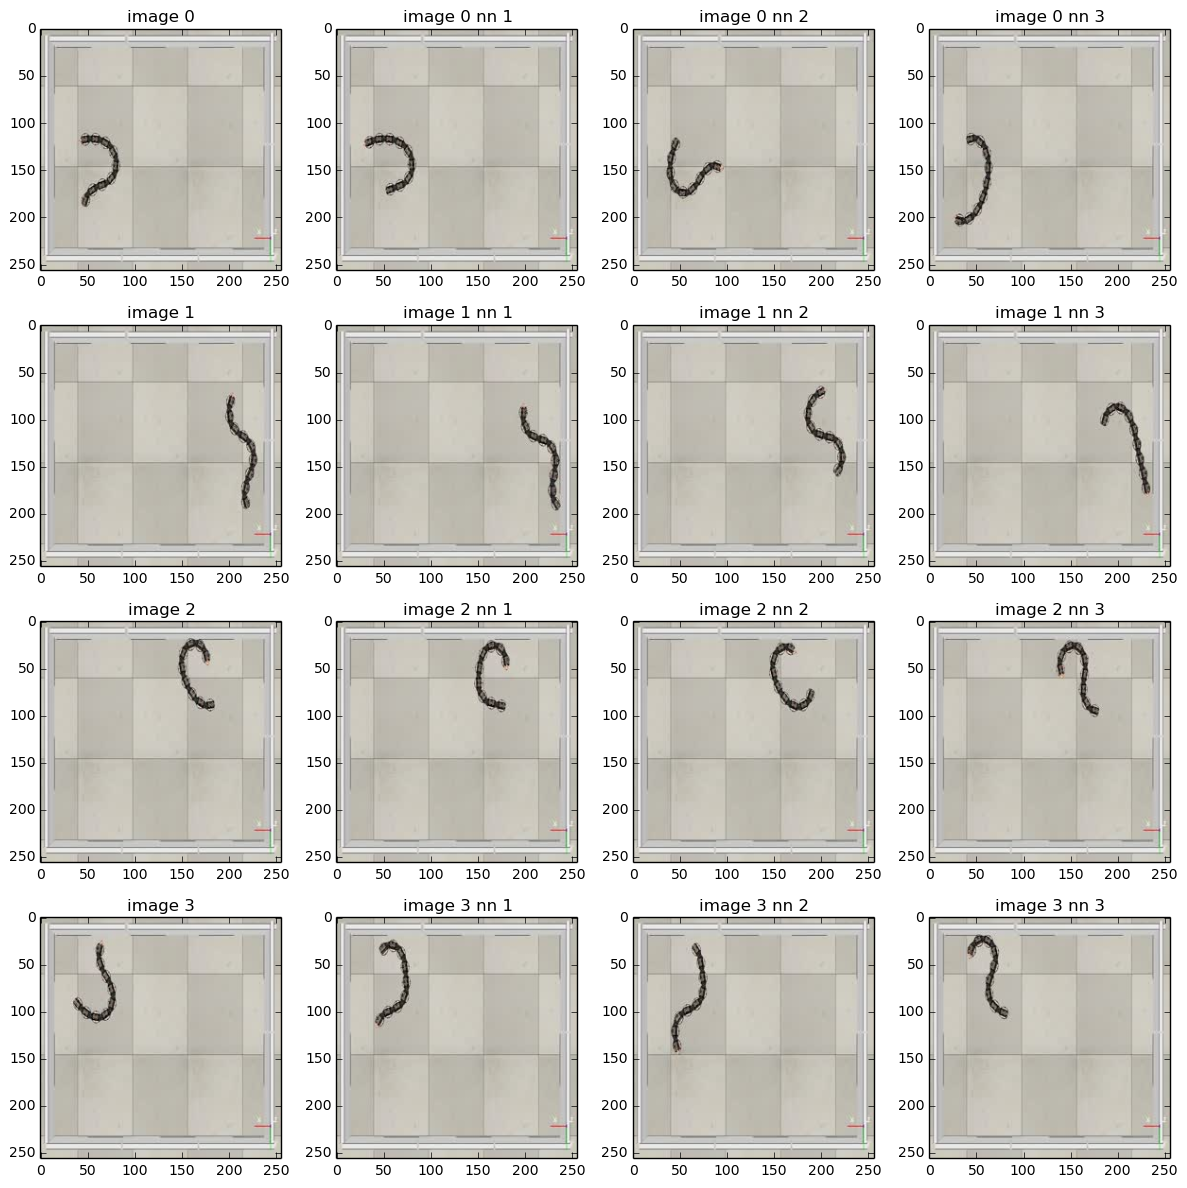

In [17]:
from IPython.core.debugger import Pdb

npoints = 4
idxs = np.random.randint(0,indices.shape[0],npoints)

valPath = '/home/ubuntu/SoftRobotRepresentation/Data/Training/0/'
def indexToImage(index):
    fname = '%s%06d.jpg'%(valPath,index)
    return plt.imread(fname)

# plt.figure(figsize=(12,12))/
fig,axes = plt.subplots(nrows=npoints,ncols=npoints,figsize=(12,12))
for i,idx in enumerate(idxs):
    plt.subplot(npoints,npoints,i*4+1)
    plt.imshow(indexToImage(randomFeatIdxs[idx]))
    plt.title('image %d'%i)
    for j in range(1,npoints):
        plt.subplot(npoints,npoints,i*npoints+j+1)
        plt.title('image %d nn %d'%(i,j))
        plt.imshow(indexToImage(randomFeatIdxs[indices[idx,j+1]]))
        
fig.tight_layout()
fig.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/NN.pdf',format='pdf')
    

(52850, 2)
(52850, 25)
13111


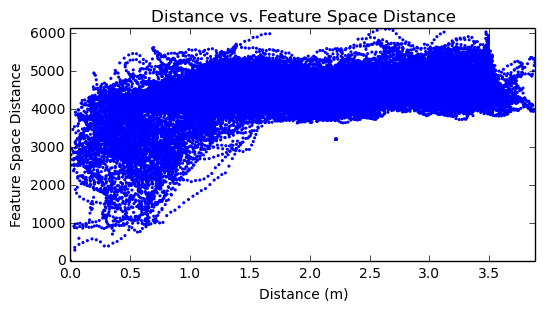

In [88]:
featuresTotal = np.load('/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy')
featuresTotal = featuresTotal[:,:-2]

pointIdxs = range(featuresTotal.shape[0])#np.random.randint(0,featuresTotal.shape[0],npoints)
featPos = featuresTotal[pointIdxs,-2:]
print featPos.shape
featOnly = featuresTotal[pointIdxs,:-2]
print featOnly.shape

randomIndex = 13111#np.random.randint(0,featPos.shape[0],1)
print randomIndex

pos = featPos[randomIndex,:]
feat = featOnly[randomIndex,:]

deltaPos = pos-featPos
deltaFeat = feat-featOnly

distPos = np.sum(deltaPos**2,axis=1)**(1./2)
distFeat = np.sum(deltaFeat**2,axis=1)**(1./2)


plt.figure(figsize=(6,3))
plt.scatter(distPos,distFeat,marker='.',linewidths=0)
plt.xlabel('Distance (m)')
plt.ylabel('Feature Space Distance')
plt.title('Distance vs. Feature Space Distance')
plt.ylim([0, np.max(distFeat)])
plt.xlim([0, np.max(distPos)])
plt.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/DistVsFeatDist.pdf',format='pdf')

# print "yep"
# np.sort(distFeat)
# print distFeat

# print np.argsort(distFeat)

# plt.figure()
# plt.hist(distFeat)

In [20]:
from sklearn import manifold

npoints = 500
indices = np.random.randint(0,feats.shape[0],npoints)
subsampled = feats[indices,:]

In [21]:
tsne = manifold.TSNE()
X = tsne.fit_transform(subsampled)

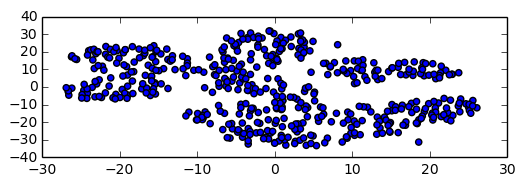

In [85]:
plt.scatter(X[:,0],X[:,1])

(52850, 29)


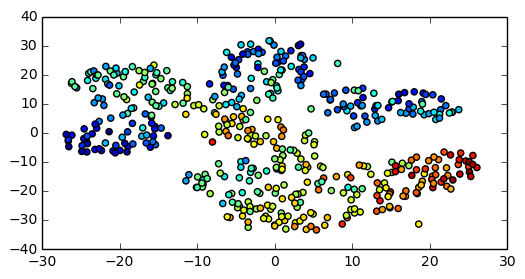

In [87]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

baseStr = '/home/ubuntu/SoftRobotRepresentation/Data/Training/0/'
def loadImage(x):
    path = baseStr+'%06d'%x+'.jpg'
    im = plt.imread(path)
    return im


plt.figure(figsize=(6,3))

def imscatter(x, y, ax=None, zoom=0.2):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for i,(x0, y0) in enumerate(zip(x, y)):
        if i%3 != 0:
            continue
        image = loadImage(indices[i])
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

featsPos = np.load('/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy')
print featsPos.shape
featsPos = featsPos[:,-4:-2]


plt.scatter(X[:,0], X[:,1], c=featsPos[indices,0]+featsPos[indices,1])#np.sum(featsPos[indices,:]**2,axis=1)**(1/2.0))
            #np.abs(featsPos[indices,0])+np.abs(featsPos[indices,1]))  
    
plt.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/tsne.pdf',format='pdf')    

# imscatter(X[:,0], X[:,1])

In [44]:
import matplotlib.cm as cm

x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))
print colors
print colors.shape

[[  5.00000000e-01   0.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  2.80392157e-01   3.38158275e-01   9.85162233e-01   1.00000000e+00]
 [  6.07843137e-02   6.36474236e-01   9.41089253e-01   1.00000000e+00]
 [  1.66666667e-01   8.66025404e-01   8.66025404e-01   1.00000000e+00]
 [  3.86274510e-01   9.84086337e-01   7.67362681e-01   1.00000000e+00]
 [  6.13725490e-01   9.84086337e-01   6.41213315e-01   1.00000000e+00]
 [  8.33333333e-01   8.66025404e-01   5.00000000e-01   1.00000000e+00]
 [  1.00000000e+00   6.36474236e-01   3.38158275e-01   1.00000000e+00]
 [  1.00000000e+00   3.38158275e-01   1.71625679e-01   1.00000000e+00]
 [  1.00000000e+00   1.22464680e-16   6.12323400e-17   1.00000000e+00]]
(10, 4)


array([[[193, 194, 178],
        [192, 193, 177],
        [190, 191, 175],
        ..., 
        [187, 184, 177],
        [184, 181, 174],
        [182, 179, 172]],

       [[186, 187, 171],
        [186, 187, 171],
        [185, 186, 170],
        ..., 
        [188, 185, 178],
        [186, 183, 176],
        [184, 181, 174]],

       [[183, 184, 168],
        [183, 184, 168],
        [184, 185, 169],
        ..., 
        [188, 185, 178],
        [186, 183, 176],
        [185, 182, 175]],

       ..., 
       [[204, 201, 194],
        [204, 201, 194],
        [204, 201, 192],
        ..., 
        [205, 203, 191],
        [205, 203, 191],
        [205, 203, 190]],

       [[204, 201, 194],
        [204, 201, 194],
        [204, 201, 192],
        ..., 
        [205, 203, 191],
        [203, 203, 191],
        [203, 204, 190]],

       [[204, 201, 194],
        [204, 201, 194],
        [204, 201, 192],
        ..., 
        [205, 203, 191],
        [203, 203, 191],
        [203, 204,

(500, 25)